# 1. Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17429465802643968882
xla_global_id: -1
]
[]


In [4]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

In [5]:
path = "./Dataset/"

# original data -> data
data = pd.read_csv(path+"train_A.csv")  
data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,1,0.532754,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.517402,T050307,A_31,NaN,NaN,20153.0,24984.0,0.21,0.22,...,53.55,52.68,49.97,56.66,63.52,1.0,210.5,214.6,201.6,191.9
2,0,0.522159,T050304,A_31,18031.0,18031.0,NaN,NaN,0.19,0.20,...,57.74,52.51,54.45,57.99,63.16,1.0,NaN,NaN,NaN,NaN
3,2,0.541429,T050304,A_31,8164.0,8164.0,NaN,NaN,0.19,0.20,...,56.38,57.10,51.49,56.08,64.40,1.0,NaN,NaN,NaN,NaN
4,1,0.526517,T050307,A_31,NaN,NaN,17014.0,21844.0,0.20,0.22,...,50.45,50.29,57.54,52.59,62.37,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2,0.548592,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,1,0.526997,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,1,0.530940,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,0,0.516681,T050304,A_31,10729.0,10729.0,NaN,NaN,0.20,0.21,...,51.30,47.66,60.00,53.75,62.58,1.0,NaN,NaN,NaN,NaN


In [14]:
t50304 = data[data['LINE'] =='T050304']
t50307 = data[data['LINE'] =='T050307']
t503 = pd.concat([t50304, t50307]).reset_index(drop=True)
t503

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,0,0.522159,T050304,A_31,18031.0,18031.0,NaN,NaN,0.19,0.20,...,57.74,52.51,54.45,57.99,63.16,1.0,NaN,NaN,NaN,NaN
1,2,0.541429,T050304,A_31,8164.0,8164.0,NaN,NaN,0.19,0.20,...,56.38,57.10,51.49,56.08,64.40,1.0,NaN,NaN,NaN,NaN
2,1,0.529130,T050304,A_31,21863.0,21863.0,NaN,NaN,0.20,0.21,...,58.07,55.23,51.33,56.78,63.48,1.0,NaN,NaN,NaN,NaN
3,1,0.528817,T050304,A_31,19078.0,19078.0,NaN,NaN,0.20,0.21,...,56.66,60.49,40.51,48.65,63.70,1.0,NaN,NaN,NaN,NaN
4,1,0.526868,T050304,A_31,22322.0,22322.0,NaN,NaN,0.20,0.21,...,55.91,56.14,40.27,56.86,61.74,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0,0.521494,T050307,A_31,NaN,NaN,896.0,896.0,0.19,0.21,...,55.25,51.05,49.83,58.79,63.26,1.0,NaN,NaN,NaN,NaN
148,2,0.540724,T050307,A_31,NaN,NaN,17860.0,17860.0,0.19,0.20,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
149,2,0.541819,T050307,A_31,NaN,NaN,19854.0,19854.0,0.20,0.21,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
150,2,0.552100,T050307,A_31,NaN,NaN,17771.0,17771.0,0.19,0.20,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


# 2. Preprocessing

1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1) 
2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
3. 결측치 처리 (KNN Imputetor, fillna(0))
4. 정규화 (Robust, MinMax, Standard)
5. 카테고리 변수 수치화 (LINE, PRODUCT_CODE) LabelEncoder

In [27]:
# 1. Handling missing values  
# Preprocessed data -> processed_data
processed_data = t503.drop(['Y_Class'], axis=1).copy()
processed_data = processed_data.fillna(0)
processed_data

,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,0.522159,T050304,A_31,18031.0,18031.0,0.0,0.0,0.19,0.20,0.19,...,57.74,52.51,54.45,57.99,63.16,1.0,0.0,0.0,0.0,0.0
1,0.541429,T050304,A_31,8164.0,8164.0,0.0,0.0,0.19,0.20,0.19,...,56.38,57.10,51.49,56.08,64.40,1.0,0.0,0.0,0.0,0.0
2,0.529130,T050304,A_31,21863.0,21863.0,0.0,0.0,0.20,0.21,0.20,...,58.07,55.23,51.33,56.78,63.48,1.0,0.0,0.0,0.0,0.0
3,0.528817,T050304,A_31,19078.0,19078.0,0.0,0.0,0.20,0.21,0.19,...,56.66,60.49,40.51,48.65,63.70,1.0,0.0,0.0,0.0,0.0
4,0.526868,T050304,A_31,22322.0,22322.0,0.0,0.0,0.20,0.21,0.20,...,55.91,56.14,40.27,56.86,61.74,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.521494,T050307,A_31,0.0,0.0,896.0,896.0,0.19,0.21,0.19,...,55.25,51.05,49.83,58.79,63.26,1.0,0.0,0.0,0.0,0.0
148,0.540724,T050307,A_31,0.0,0.0,17860.0,17860.0,0.19,0.20,0.19,...,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0
149,0.541819,T050307,A_31,0.0,0.0,19854.0,19854.0,0.20,0.21,0.20,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
150,0.552100,T050307,A_31,0.0,0.0,17771.0,17771.0,0.19,0.20,0.19,...,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0


In [28]:
# 2. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
# Get the counts of unique values per column
value_counts = processed_data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))

# Filter columns with only one unique value
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index

processed_data = processed_data.drop(duplicated_columns, axis=1)
processed_data

,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,0.522159,T050304,A_31,18031.0,18031.0,0.0,0.0,0.19,0.20,0.19,...,57.74,52.51,54.45,57.99,63.16,1.0,0.0,0.0,0.0,0.0
1,0.541429,T050304,A_31,8164.0,8164.0,0.0,0.0,0.19,0.20,0.19,...,56.38,57.10,51.49,56.08,64.40,1.0,0.0,0.0,0.0,0.0
2,0.529130,T050304,A_31,21863.0,21863.0,0.0,0.0,0.20,0.21,0.20,...,58.07,55.23,51.33,56.78,63.48,1.0,0.0,0.0,0.0,0.0
3,0.528817,T050304,A_31,19078.0,19078.0,0.0,0.0,0.20,0.21,0.19,...,56.66,60.49,40.51,48.65,63.70,1.0,0.0,0.0,0.0,0.0
4,0.526868,T050304,A_31,22322.0,22322.0,0.0,0.0,0.20,0.21,0.20,...,55.91,56.14,40.27,56.86,61.74,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.521494,T050307,A_31,0.0,0.0,896.0,896.0,0.19,0.21,0.19,...,55.25,51.05,49.83,58.79,63.26,1.0,0.0,0.0,0.0,0.0
148,0.540724,T050307,A_31,0.0,0.0,17860.0,17860.0,0.19,0.20,0.19,...,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0
149,0.541819,T050307,A_31,0.0,0.0,19854.0,19854.0,0.20,0.21,0.20,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
150,0.552100,T050307,A_31,0.0,0.0,17771.0,17771.0,0.19,0.20,0.19,...,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0.0,0.0


In [29]:
# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_data.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_data = pd.concat([processed_data.iloc[:,:4], df], axis=1)
processed_data

,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,...,X_2839,X_2840,X_2841,X_2842,X_2843,X_2871,X_2872,X_2873,X_2874,X_2875
0,0.522159,T050304,A_31,18031.0,18031.0,0.0,0.0,0.19,0.20,0.19,...,5.02,7.02,40.56,0.000156,0.000008,1.0,0.0,0.0,0.0,0.0
1,0.541429,T050304,A_31,8164.0,8164.0,0.0,0.0,0.19,0.20,0.19,...,5.01,6.53,39.58,0.000120,0.000008,1.0,0.0,0.0,0.0,0.0
2,0.529130,T050304,A_31,21863.0,21863.0,0.0,0.0,0.20,0.21,0.20,...,4.99,7.04,41.03,0.000174,0.000010,1.0,0.0,0.0,0.0,0.0
3,0.528817,T050304,A_31,19078.0,19078.0,0.0,0.0,0.20,0.21,0.19,...,4.52,7.01,40.62,0.000398,0.000033,1.0,0.0,0.0,0.0,0.0
4,0.526868,T050304,A_31,22322.0,22322.0,0.0,0.0,0.20,0.21,0.20,...,5.00,7.00,36.53,0.000187,0.000011,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.521494,T050307,A_31,0.0,0.0,896.0,896.0,0.19,0.21,0.19,...,4.50,6.99,40.08,0.001350,0.000012,1.0,0.0,0.0,0.0,0.0
148,0.540724,T050307,A_31,0.0,0.0,17860.0,17860.0,0.19,0.20,0.19,...,5.01,6.54,39.11,0.001160,0.000018,1.0,0.0,0.0,0.0,0.0
149,0.541819,T050307,A_31,0.0,0.0,19854.0,19854.0,0.20,0.21,0.20,...,5.00,7.05,36.54,0.001150,0.000009,0.0,0.0,0.0,0.0,0.0
150,0.552100,T050307,A_31,0.0,0.0,17771.0,17771.0,0.19,0.20,0.19,...,5.04,7.01,38.03,0.001170,0.000006,1.0,0.0,0.0,0.0,0.0


In [30]:
# 4. Regularization 
rs = RobustScaler()
ss = StandardScaler()

processed_data.iloc[:, 4:] = rs.fit_transform(processed_data.iloc[:, 4:])
processed_data

,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,...,X_2839,X_2840,X_2841,X_2842,X_2843,X_2871,X_2872,X_2873,X_2874,X_2875
0,0.522159,T050304,A_31,18031.0,0.748691,0.000000,0.000000,-1.0,-1.0,-1.0,...,0.5,0.5,0.253521,-0.177554,-0.309917,0.0,0.0,0.0,0.0,0.0
1,0.541429,T050304,A_31,8164.0,0.156354,0.000000,0.000000,-1.0,-1.0,-1.0,...,0.0,-24.0,-0.248399,-0.212012,-0.271350,0.0,0.0,0.0,0.0,0.0
2,0.529130,T050304,A_31,21863.0,0.978734,0.000000,0.000000,0.0,0.0,0.0,...,-1.0,1.5,0.494238,-0.160325,0.026171,0.0,0.0,0.0,0.0,0.0
3,0.528817,T050304,A_31,19078.0,0.811544,0.000000,0.000000,0.0,0.0,-1.0,...,-24.5,0.0,0.284251,0.054080,6.398072,0.0,0.0,0.0,0.0,0.0
4,0.526868,T050304,A_31,22322.0,1.006288,0.000000,0.000000,0.0,0.0,0.0,...,-0.5,-0.5,-1.810499,-0.147882,0.337466,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.521494,T050307,A_31,0.0,-0.333749,0.109774,0.097883,-1.0,0.0,-1.0,...,-25.5,-1.0,0.007682,0.965303,0.805785,0.0,0.0,0.0,0.0,0.0
148,0.540724,T050307,A_31,0.0,-0.333749,2.188122,1.951113,-1.0,-1.0,-1.0,...,0.0,-23.5,-0.489117,0.783441,2.265840,0.0,0.0,0.0,0.0,0.0
149,0.541819,T050307,A_31,0.0,-0.333749,2.432418,2.168947,0.0,0.0,0.0,...,-0.5,2.0,-1.805378,0.773869,-0.252066,-1.0,0.0,0.0,0.0,0.0
150,0.552100,T050307,A_31,0.0,-0.333749,2.177218,1.941390,-1.0,-1.0,-1.0,...,1.5,0.0,-1.042254,0.793013,-1.034435,0.0,0.0,0.0,0.0,0.0


In [31]:
# 5. Label Encoding 
cat_cols = ['PRODUCT_CODE', 'LINE']

for col in cat_cols:
    le = LabelEncoder()
    processed_data[col] = le.fit_transform(processed_data[col])
    print(le.classes_)

processed_data.head()

['A_31']
['T050304' 'T050307']


,Y_Quality,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,...,X_2839,X_2840,X_2841,X_2842,X_2843,X_2871,X_2872,X_2873,X_2874,X_2875
0,0.522159,0,0,18031.0,0.748691,0.0,0.0,-1.0,-1.0,-1.0,...,0.5,0.5,0.253521,-0.177554,-0.309917,0.0,0.0,0.0,0.0,0.0
1,0.541429,0,0,8164.0,0.156354,0.0,0.0,-1.0,-1.0,-1.0,...,0.0,-24.0,-0.248399,-0.212012,-0.271350,0.0,0.0,0.0,0.0,0.0
2,0.529130,0,0,21863.0,0.978734,0.0,0.0,0.0,0.0,0.0,...,-1.0,1.5,0.494238,-0.160325,0.026171,0.0,0.0,0.0,0.0,0.0
3,0.528817,0,0,19078.0,0.811544,0.0,0.0,0.0,0.0,-1.0,...,-24.5,0.0,0.284251,0.054080,6.398072,0.0,0.0,0.0,0.0,0.0
4,0.526868,0,0,22322.0,1.006288,0.0,0.0,0.0,0.0,0.0,...,-0.5,-0.5,-1.810499,-0.147882,0.337466,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 6. Multicollinearity 
from collinearity import SelectNonCollinear

nonX_data = processed_data.iloc[:, :3]
X_data = processed_data.iloc[:, 3:]

selector = SelectNonCollinear(0.9)
selector.fit(X_data.values)
mask = selector.get_support() # True or False

selected_df = pd.DataFrame(X_data.loc[:,mask])
processed_data = pd.concat([nonX_data, selected_df], axis=1)
processed_data

In [32]:
# 5. 차원 축소
from sklearn.decomposition import PCA 

nonX_data = processed_data.iloc[:, :3]
X_data = processed_data.iloc[:, 3:]

pca = PCA(n_components=40)
pca_data = pca.fit_transform(X_data) 
pca_df = pd.DataFrame(pca_data) # , columns=['X1', 'X2', 'X3']

processed_data = pd.concat([nonX_data, pca_df], axis=1)
processed_data

,Y_Quality,LINE,PRODUCT_CODE,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
0,0.522159,0,0,-52622.898199,9049.420369,-60.682242,-21.582333,-32.792102,-12.924548,0.040709,...,0.016573,10.028465,-3.869230,0.915631,1.585042,1.604775,-3.546667,3.991132,-1.004050,-1.270255
1,0.541429,0,0,-52496.878517,-816.806555,-62.030746,12.412239,-25.111262,42.125579,45.537222,...,-2.778679,3.603479,-3.237140,-4.282360,2.819291,-0.395325,0.119325,3.015013,-2.839700,-2.363850
2,0.529130,0,0,-52673.758429,12881.014480,-61.221773,-39.023255,-34.218526,-54.249466,7.420738,...,0.467154,-5.220696,0.348730,-2.212095,-1.660350,1.390988,0.213147,-0.407780,3.486158,-0.507040
3,0.528817,0,0,-52637.637480,10096.157766,-41.409744,-28.878255,236.912610,-55.541897,26.689425,...,-5.121389,1.922758,0.111878,-0.532647,-1.212360,4.291768,-2.640606,1.133877,-0.015919,0.360034
4,0.526868,0,0,-52678.281955,13339.807273,944.563653,65.449032,-122.781578,4.984095,-29.216885,...,-1.212654,-1.494629,-0.113214,-0.632523,-0.279593,-1.470793,0.538408,-2.609433,1.415930,1.779608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.521494,1,0,-52392.801392,-8979.967144,-76.309314,29.883651,-43.667290,32.255364,-21.722688,...,-9.528825,1.120541,-1.913000,2.267046,2.925277,3.486750,-0.609378,1.690609,2.072928,3.559619
148,0.540724,1,0,517598.616785,-1679.039107,-46.156584,-281.418083,-24.302427,-20.700733,-34.466574,...,-5.033490,0.925739,-1.023040,-0.749604,-0.735048,3.392185,-0.493962,-1.362893,-0.618163,-0.478420
149,0.541819,1,0,-52392.068653,-8980.220839,927.285644,131.898155,-130.172976,42.574028,-31.595594,...,5.545342,1.347957,-0.555514,3.106862,-0.768964,1.208374,1.376025,1.261990,-1.958145,-1.145674
150,0.552100,1,0,517598.616925,-1679.030448,-46.123893,-281.478288,-26.055409,-20.428981,-35.114276,...,2.694487,0.791487,0.628003,-2.246024,0.194238,0.631473,5.575045,4.057199,2.834594,-2.139232


# 3. Data Split

In [33]:
# Divide processed_data to input_data_X and input_data_y 
input_data = processed_data.copy()
input_data_y = processed_data['Y_Quality']
input_data_X = processed_data.drop(['Y_Quality'], axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = SEED,
    shuffle=True
)

# valid/train 로 split
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2, 
    random_state = SEED,
    shuffle=True
)

print('Input Data X:', input_data_X.shape, 'Input Data y:', input_data_y.shape)
print('X_train:', train_X.shape, 'y_train:', train_y.shape)
print('X_valid:', valid_X.shape, 'y_train:', valid_y.shape)
print('X_test:', test_X.shape, 'y_train:', test_y.shape)

Input Data X: (152, 42) Input Data y: (152,)
X_train: (96, 42) y_train: (96,)
X_valid: (25, 42) y_train: (25,)
X_test: (31, 42) y_train: (31,)


In [34]:
train_X

,LINE,PRODUCT_CODE,0,1,2,3,4,5,6,7,...,30,31,32,33,34,35,36,37,38,39
32,0,0,-52606.143486,7687.548104,-65.290783,-24.092003,-38.851129,4.410212,-25.045245,4.793919,...,4.693552,-4.152557,3.123620,-1.489438,-8.210108,5.005725,0.321102,-2.556265,5.567301,-1.101324
110,1,0,-52392.038737,-8980.117900,-69.441592,4.601582,-36.360045,-9.955461,-32.738368,55.911268,...,2.318078,-0.780711,-0.015945,2.933729,-4.211102,1.397172,1.622317,0.502493,-0.897444,-1.670687
20,0,0,-52682.696374,13564.041604,-62.214688,-36.297983,-36.061523,-4.170483,-18.300900,0.929706,...,6.161962,-2.481951,-2.630284,-0.360015,-2.609172,2.283871,-0.988586,2.802849,3.081842,2.157486
72,0,0,-52492.979127,-1155.629750,-71.701165,10.240247,-42.242203,22.376363,-17.453617,4.802790,...,-1.847594,-5.699713,-1.103250,-1.385949,3.679163,-2.247750,-0.447400,-0.699942,1.774769,0.043412
88,1,0,-52392.268705,-8979.953044,-76.248213,29.933523,-44.997515,33.146002,-21.936285,4.727687,...,0.689530,-2.984616,-1.503362,6.570745,2.023031,-1.308016,-3.488985,6.501045,0.767826,5.824115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,0,0,-52720.494222,16581.778122,-60.260005,-46.275585,-35.658665,-8.856658,-17.082305,-0.035161,...,0.370333,1.213550,-1.168425,-0.019937,-1.711306,-0.004264,0.683457,0.381918,-1.890813,1.334474
140,1,0,-52392.182116,-8980.846426,-76.647921,1.518869,-89.239152,-429.451397,229.753159,-112.899267,...,-1.999946,1.943495,2.538088,-3.161369,-10.705825,-14.284867,-3.898924,3.427246,1.132805,-1.755601
59,0,0,-52694.857049,14583.952569,-61.384880,-42.324375,-34.985654,-6.209874,-19.121513,-0.264964,...,-2.827418,0.896875,2.298169,-1.039867,2.517654,-0.020711,-2.395323,0.460872,1.055491,-1.818311
5,0,0,-52716.667359,16343.812959,-60.320431,-45.452460,-34.704295,-9.039060,-18.073156,1.356387,...,-5.824852,9.759145,-2.902779,10.199005,2.873852,-0.772911,0.773225,4.204810,5.445154,-2.432577


# 4. Modeling 

1. Isolation Forest 
2. LOF (Local Outlier Factor)
3. PCA 
4. AutoEncoder 

In [35]:
from pycaret.regression import *
from time import time

In [36]:
# Setup Environment  
cat_cols = ['LINE', 'PRODUCT_CODE']
FOLD = 5

reg = setup(data = input_data, 
            train_size = 0.8,
            # test_data = test,
            target = 'Y_Quality',
            ignore_features = cat_cols,
            preprocess = False,  # default True
#            categorical_features = cat_cols,
#            fold_strategy = 'stratifiedkfold', # default 
            #numeric_features = num_cols,
            #ordinal_features = ord_dict,
            #high_cardinality_features = ['religion'],
            #high_cardinality_method = 'frequency',
            #handle_unknown_categorical = True,
            #normalize = True,
            #normalize_method = 'zscore', 
            #feature_selection = True, 
            #imputation_type='iterative',
            fold=FOLD, # defualt 10 
            fold_shuffle=True,
            use_gpu = True,
            session_id = SEED)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,42
1,Target,Y_Quality
2,Target type,Regression
3,Original data shape,"(152, 43)"
4,Transformed data shape,"(152, 41)"
5,Transformed train set shape,"(121, 41)"
6,Transformed test set shape,"(31, 41)"
7,Ignore features,2
8,Numeric features,40


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [37]:
# EG, Cat, GBR, LGBM, XGB
top5 = compare_models(sort='r2', n_select=5, fold=FOLD, exclude=['lar', 'par', 'huber'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.0066,0.0001,0.0094,0.2149,0.0061,0.0124,0.0260
et,Extra Trees Regressor,0.0073,0.0001,0.0095,0.2042,0.0062,0.0136,0.1460
ada,AdaBoost Regressor,0.0075,0.0001,0.0096,0.1887,0.0062,0.0140,0.0780
catboost,CatBoost Regressor,0.0073,0.0001,0.0097,0.1835,0.0063,0.0137,10.4760
rf,Random Forest Regressor,0.0073,0.0001,0.0097,0.1708,0.0063,0.0138,0.1920
gbr,Gradient Boosting Regressor,0.0073,0.0001,0.0098,0.1372,0.0064,0.0137,0.1660
lasso,Lasso Regression,0.0077,0.0001,0.0101,0.0982,0.0066,0.0145,0.0060
llar,Lasso Least Angle Regression,0.0077,0.0001,0.0101,0.0982,0.0066,0.0145,0.0080
en,Elastic Net,0.0078,0.0001,0.0101,0.0965,0.0066,0.0145,0.0060
lightgbm,Light Gradient Boosting Machine,0.0078,0.0001,0.0101,0.0844,0.0066,0.0146,0.1700


In [38]:
total_models = []
tuned_models = []

for i, model in enumerate(top5):
    cell_start_time = time() 
    print(top5[i])
    model = create_model(model, fold=FOLD)
    #tuned_model = tune_model(model, fold=5, optimize='r2', choose_better=True)
    total_models.append(model)
    #tuned_models.append(tuned_model)
    cell_end_time = time()
    print("CELL RUN TIME: ", cell_end_time - cell_start_time)

KNeighborsRegressor(n_jobs=-1)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0040,0.0000,0.0053,0.6608,0.0035,0.0075
1,0.0056,0.0001,0.0073,0.4149,0.0047,0.0104
2,0.0089,0.0002,0.0143,0.0357,0.0092,0.0164
3,0.0067,0.0001,0.0091,0.0979,0.0060,0.0127
4,0.0080,0.0001,0.0111,-0.1348,0.0072,0.0151
Mean,0.0066,0.0001,0.0094,0.2149,0.0061,0.0124
Std,0.0017,0.0001,0.0031,0.2853,0.0020,0.0032


CELL RUN TIME:  0.277998685836792
ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0061,0.0000,0.0071,0.3951,0.0046,0.0115
1,0.0062,0.0001,0.0075,0.3678,0.0049,0.0116
2,0.0097,0.0002,0.0141,0.0510,0.0092,0.0179
3,0.0067,0.0001,0.0086,0.1919,0.0056,0.0127
4,0.0075,0.0001,0.0103,0.0149,0.0067,0.0142
Mean,0.0073,0.0001,0.0095,0.2042,0.0062,0.0136
Std,0.0013,0.0001,0.0026,0.1566,0.0016,0.0024


CELL RUN TIME:  1.0283560752868652
AdaBoostRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0056,0.0001,0.0072,0.3754,0.0047,0.0106
1,0.0076,0.0001,0.0088,0.1374,0.0057,0.0143
2,0.0095,0.0002,0.0132,0.1699,0.0086,0.0175
3,0.0064,0.0001,0.0081,0.2861,0.0053,0.0122
4,0.0081,0.0001,0.0106,-0.0255,0.0069,0.0152
Mean,0.0075,0.0001,0.0096,0.1887,0.0062,0.0140
Std,0.0013,0.0000,0.0021,0.1365,0.0014,0.0024


CELL RUN TIME:  0.6708712577819824


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0054,0.0001,0.0072,0.3670,0.0047,0.0102
1,0.0072,0.0001,0.0090,0.0997,0.0059,0.0136
2,0.0101,0.0002,0.0141,0.0514,0.0092,0.0185
3,0.0064,0.0001,0.0080,0.3036,0.0052,0.0122
4,0.0075,0.0001,0.0099,0.0958,0.0065,0.0141
Mean,0.0073,0.0001,0.0097,0.1835,0.0063,0.0137
Std,0.0015,0.0001,0.0024,0.1267,0.0015,0.0027


CELL RUN TIME:  65.34018182754517
RandomForestRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0061,0.0001,0.0077,0.2816,0.0050,0.0115
1,0.0068,0.0001,0.0084,0.2105,0.0055,0.0127
2,0.0097,0.0002,0.0137,0.1122,0.0088,0.0179
3,0.0065,0.0001,0.0085,0.2157,0.0056,0.0123
4,0.0077,0.0001,0.0102,0.0342,0.0067,0.0145
Mean,0.0073,0.0001,0.0097,0.1708,0.0063,0.0138
Std,0.0013,0.0000,0.0022,0.0871,0.0014,0.0023


CELL RUN TIME:  1.2450919151306152


In [39]:
blender_top5 = blend_models(estimator_list=total_models)
#blender_tuned5 = blend_models(estimator_list=tuned_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0050,0.0000,0.0064,0.4964,0.0042,0.0095
1,0.0062,0.0001,0.0077,0.3353,0.0050,0.0116
2,0.0093,0.0002,0.0136,0.1222,0.0088,0.0171
3,0.0064,0.0001,0.0081,0.2903,0.0053,0.0121
4,0.0075,0.0001,0.0101,0.0525,0.0066,0.0141
Mean,0.0069,0.0001,0.0092,0.2594,0.0060,0.0129
Std,0.0014,0.0001,0.0025,0.1578,0.0016,0.0026


In [40]:
# for naive models 
total_predictions = []
for model in total_models: 
    pred = predict_model(model)
    total_predictions.append(pred)
print() 

# for tuned models 
# for model in tuned_models: 
#     prediction = predict_model(model)
# print() 

# for blended model 
pred_blend_top5 = predict_model(blender_top5)
print() 

# for blended model (tuned)
#pred_blend_tuned5 = predict_model(blender_tuned5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0060,0.0001,0.0085,0.3575,0.0055,0.0113


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0060,0.0001,0.0082,0.3963,0.0054,0.0113


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.0079,0.0001,0.0105,0.0211,0.0068,0.0149


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0067,0.0001,0.0092,0.2418,0.0060,0.0126


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0069,0.0001,0.0090,0.2780,0.0059,0.0130


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0062,0.0001,0.0085,0.3494,0.0055,0.0117


In [41]:
CHECK = 1

In [42]:
evaluate_model(total_models[CHECK])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

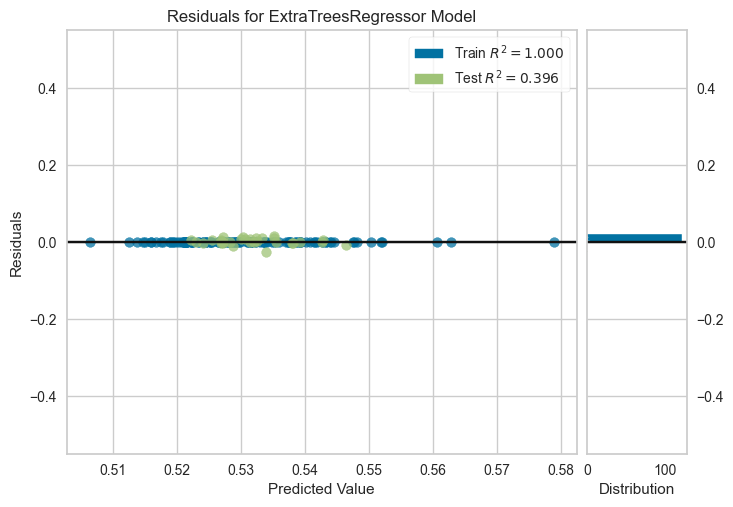

In [43]:
plot_model(total_models[CHECK], plot='residuals')

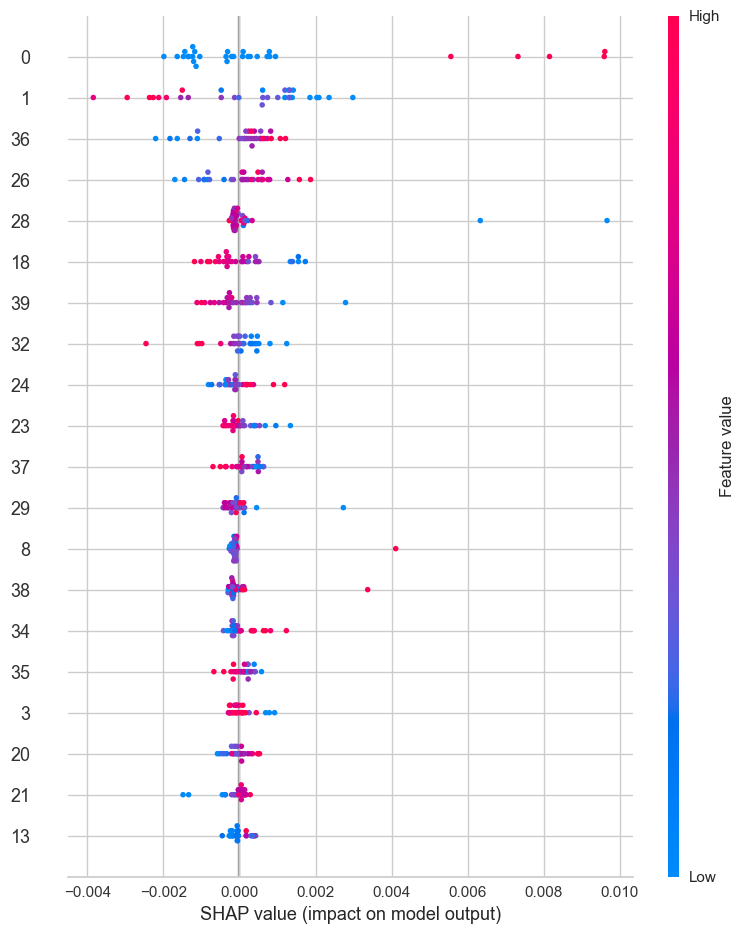

In [44]:
interpret_model(total_models[CHECK], plot='summary')

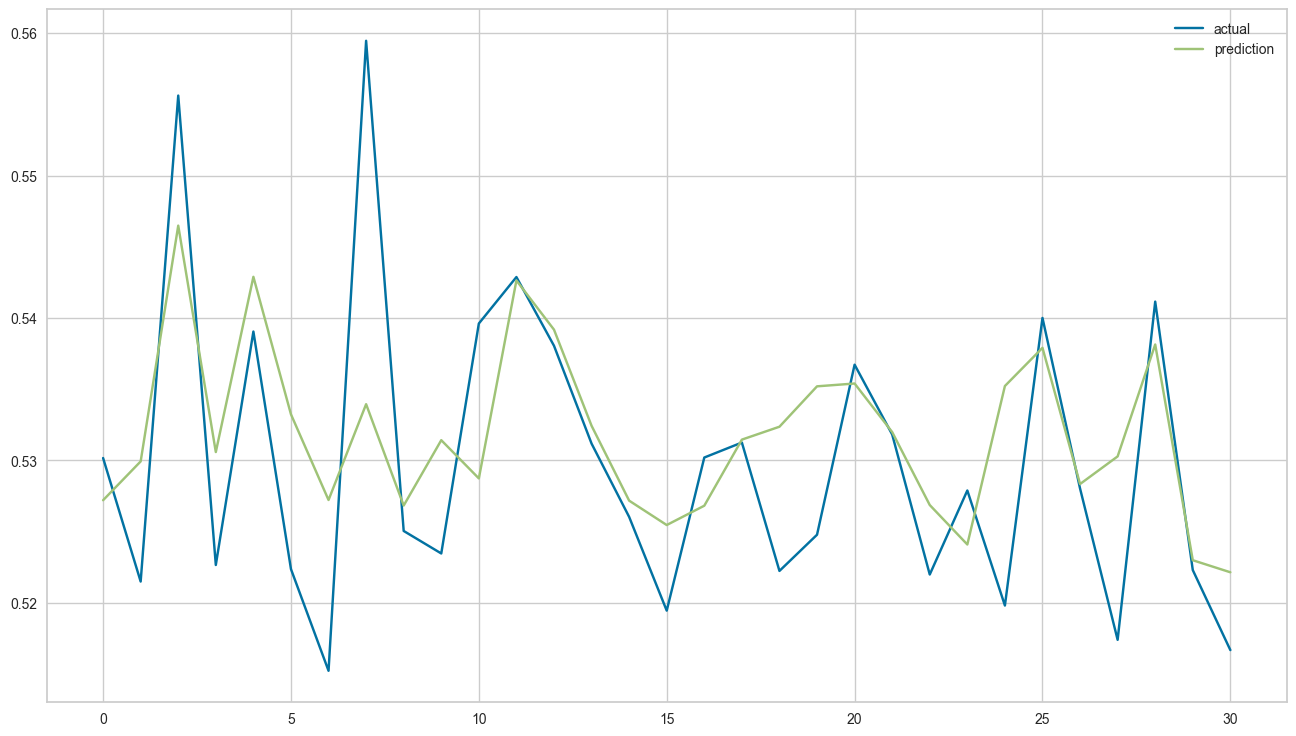

In [45]:
def graph(pred, true) :
    plt.figure(figsize=(16, 9))
    plt.plot(true, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

true_y = total_predictions[CHECK]['Y_Quality'].to_numpy()
pred_y = total_predictions[CHECK]['prediction_label'].to_numpy()
graph(pred_y, true_y)